In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
csvPath = "./chicago-west-nile-virus-mosquito-test-results/west-nile-virus-wnv-mosquito-test-results.csv"

In [3]:
## Read Data

df = pd.read_csv(csvPath, encoding="utf-8")
df = df.loc[df['RESULT'] == 'positive']
df.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
93,2018,38,47646,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,50,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
103,2018,38,47649,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,19,positive,CULEX RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
128,2018,38,47648,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,50,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
134,2018,38,47637,25XX W GRAND AVE,T046,GRAVID,2018-09-20T00:09:00.000,5,positive,CULEX PIPIENS/RESTUANS,41.892220,-87.691698,"{'longitude': '-87.69169772868295', 'latitude'...",46.0,177.0,21184.0,24.0,41.0
176,2018,37,47562,25XX W GRAND AVE,T046B,SENTINEL,2018-09-13T00:09:00.000,42,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0


In [4]:
df.describe()

,SEASON YEAR,WEEK,TEST ID,NUMBER OF MOSQUITOES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
count,2338.000000,2338.000000,2338.000000,2338.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,2013.359281,32.351155,37374.218135,27.734388,41.858417,-87.710915,28.093822,422.210526,19650.413043,40.215103,31.282037
std,3.284551,2.634057,7456.867265,17.377089,0.115472,0.077597,13.820515,249.050932,5667.591178,22.574549,12.667966
min,2007.000000,23.000000,20467.000000,1.000000,41.644720,-87.854473,1.000000,6.000000,4299.000000,4.000000,3.000000
25%,2012.000000,30.000000,33842.750000,12.000000,41.754148,-87.778235,19.000000,177.000000,21202.000000,17.000000,23.000000
50%,2014.000000,32.000000,38825.500000,27.000000,41.891455,-87.723962,29.000000,442.000000,21867.000000,40.000000,34.000000
75%,2016.000000,34.000000,43446.000000,48.000000,41.964405,-87.656762,38.000000,654.000000,22254.000000,62.000000,40.000000
max,2018.000000,39.000000,47649.000000,50.000000,42.013029,-87.531060,50.000000,787.000000,22620.000000,77.000000,53.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338 entries, 93 to 26715
Data columns (total 18 columns):
SEASON YEAR                   2338 non-null int64
WEEK                          2338 non-null int64
TEST ID                       2338 non-null int64
BLOCK                         2338 non-null object
TRAP                          2338 non-null object
TRAP_TYPE                     2338 non-null object
TEST DATE                     2338 non-null object
NUMBER OF MOSQUITOES          2338 non-null int64
RESULT                        2338 non-null object
SPECIES                       2338 non-null object
LATITUDE                      1748 non-null float64
LONGITUDE                     1748 non-null float64
LOCATION                      1748 non-null object
Wards                         1748 non-null float64
Census Tracts                 1748 non-null float64
Zip Codes                     1748 non-null float64
Community Areas               1748 non-null float64
Historical Wards 2003-

In [6]:
## Preprocess data

# df['TEST DATE INT'] = pd.to_datetime(df['TEST DATE']).astype('int64')//1e9
df['TEST DATE INT'] = df['TEST DATE'].str.split('T').str[0].str.replace('-', '').astype('int64')

nonNumCol = ['TRAP', 'BLOCK', 'TRAP_TYPE', 'SPECIES', 'Zip Codes']
for col in nonNumCol:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

df_dropped = df.drop(columns=['LOCATION', 'TEST DATE', 'TEST ID', 'TRAP', 'SEASON YEAR', 'WEEK', 'RESULT'])
df_dropped = df_dropped.dropna()
df_dropped.head()

,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT
93,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
103,42,2,19,2,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
128,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
134,42,1,5,1,41.892220,-87.691698,46.0,177.0,9,24.0,41.0,20180920
176,42,2,42,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180913


In [7]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 93 to 26715
Data columns (total 12 columns):
BLOCK                         1748 non-null int8
TRAP_TYPE                     1748 non-null int8
NUMBER OF MOSQUITOES          1748 non-null int64
SPECIES                       1748 non-null int8
LATITUDE                      1748 non-null float64
LONGITUDE                     1748 non-null float64
Wards                         1748 non-null float64
Census Tracts                 1748 non-null float64
Zip Codes                     1748 non-null int8
Community Areas               1748 non-null float64
Historical Wards 2003-2015    1748 non-null float64
TEST DATE INT                 1748 non-null int64
dtypes: float64(6), int64(2), int8(4)
memory usage: 129.7 KB


In [8]:
X = df_dropped.to_numpy()

In [9]:
neigh = NearestNeighbors(2, 0.4)
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=2, p=2, radius=0.4)

In [10]:
dist, _ = neigh.kneighbors(X)
dist = dist[:,1]
max_dist = max(dist)
min_dist = min(dist)
avg_dist = sum(dist) / len(dist)
med_dist = np.median(dist)

print('Max distance: ', max_dist)
print('Min distance: ', min_dist)
print('Average distance: ', avg_dist)
print('Median distance: ', med_dist)

Max distance:  152.27612164780223
Min distance:  0.0
Average distance:  22.268892584692043
Median distance:  11.045361017187261


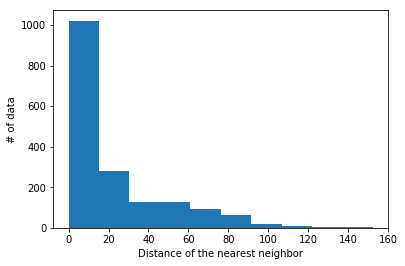

In [11]:
plt.hist(dist)
plt.ylabel('# of data')
plt.xlabel('Distance of the nearest neighbor')
plt.show()

In [12]:
neighbors = neigh.radius_neighbors(X, radius=max_dist, return_distance=False)
neighbors = np.array([len(x) for x in neighbors])

max_neighbors = max(neighbors)
min_neighbors = min(neighbors)
avg_neighbors = sum(neighbors) / len(neighbors)
med_neighbors = np.median(neighbors)
print('Max neighbors: ', max_neighbors)
print('Min neighbors: ', min_neighbors)
print('Average neighbors: ', avg_neighbors)
print('Median neighbors: ', med_neighbors)

Max neighbors:  163
Min neighbors:  2
Average neighbors:  61.50114416475972
Median neighbors:  54.0


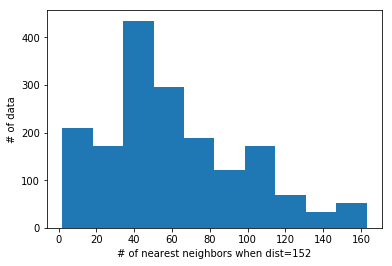

In [13]:
plt.hist(neighbors)
plt.ylabel('# of data')
plt.xlabel('# of nearest neighbors when dist=%d' % max_dist)
plt.show()

In [21]:
## Draw Silhouette Score

s_scores = []
cluster_num = []
for i in range(min_neighbors, max_neighbors + 1):
    eps=153
    mins=i

    dbscan = DBSCAN(eps=eps, min_samples=mins)
    labels = dbscan.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    label, count = np.unique(labels, return_counts=True)
    
    s_scores.append(silhouette_avg)
    cluster_num.append(len(label))

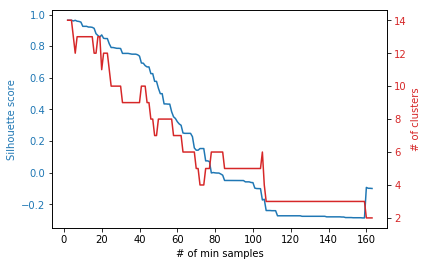

In [28]:
x = range(min_neighbors, max_neighbors + 1)
fig, ax_scores = plt.subplots()

color = 'tab:blue'
ax_scores.plot(x, s_scores, color=color)
ax_scores.set_xlabel('# of min samples')
ax_scores.set_ylabel('Silhouette score', color=color)
ax_scores.tick_params(axis='y', labelcolor=color)

ax_clusters = ax_scores.twinx()

color = 'tab:red'
ax_clusters.plot(x, cluster_num, color=color)
ax_clusters.set_ylabel('# of clusters', color=color)
ax_clusters.tick_params(axis='y', labelcolor=color)

plt.show()

In [51]:
eps=153
mins=5

In [52]:
## Clustering

dbscan = DBSCAN(eps=eps, min_samples=mins)
labels = dbscan.fit_predict(X)

label, count = np.unique(labels, return_counts=True)
label_dict = dict(zip(label, count))
print(label_dict)

{-1: 9, 0: 138, 1: 89, 2: 352, 3: 71, 4: 196, 5: 192, 6: 328, 7: 28, 8: 46, 9: 9, 10: 78, 11: 212}


In [53]:
df_label = pd.DataFrame(label_dict.values())
df_label.columns = ['Amount']
df_label = df_label.transpose()
df_label.columns = label_dict.keys()

display(df_label)

,-1,0,1,2,3,4,5,6,7,8,9,10,11
Amount,9,138,89,352,71,196,192,328,28,46,9,78,212


In [54]:
## Evaluate

silhouette_avg = silhouette_score(X, labels)
print('The average silhouette_score is : ', silhouette_avg)

The average silhouette_score is :  0.9592370906953712


In [55]:
df_dropped['CLUSTERS'] = labels

In [56]:
## Analysis

for c in label_dict:
    display(df_dropped.loc[df_dropped['CLUSTERS'] == c])

,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
14802,85,1,46,1,41.923887,-87.778910,21.0,78.0,38,19.0,52.0,20110923,-1
15809,80,1,50,1,41.872873,-87.764737,7.0,67.0,27,26.0,52.0,20110729,-1
17966,96,1,43,1,42.007998,-87.778235,29.0,781.0,35,12.0,34.0,20100805,-1
19251,85,1,1,2,41.923887,-87.778910,21.0,78.0,38,19.0,52.0,20090925,-1
19518,22,1,8,1,41.904773,-87.755686,45.0,600.0,0,26.0,4.0,20090914,-1
19661,69,1,4,1,41.659236,-87.612015,43.0,9.0,23,51.0,30.0,20090825,-1
19669,111,1,42,1,41.988586,-87.854473,29.0,64.0,28,75.0,34.0,20090825,-1
19797,10,1,29,1,41.676887,-87.661222,22.0,662.0,26,50.0,45.0,20090813,-1
20242,80,1,38,1,41.872873,-87.764737,7.0,67.0,27,26.0,52.0,20090724,-1


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
93,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920,0
103,42,2,19,2,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920,0
128,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920,0
134,42,1,5,1,41.892220,-87.691698,46.0,177.0,9,24.0,41.0,20180920,0
176,42,2,42,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180913,0
235,71,1,4,1,41.802359,-87.643076,4.0,84.0,8,59.0,12.0,20180906,0
248,65,1,22,1,41.774841,-87.728006,15.0,6.0,24,63.0,23.0,20180906,0
259,20,1,4,1,41.657069,-87.546049,47.0,787.0,30,52.0,47.0,20180906,0
299,56,1,6,1,41.953664,-87.724987,50.0,326.0,14,16.0,28.0,20180830,0
309,98,1,44,1,42.010643,-87.806797,29.0,654.0,28,77.0,34.0,20180830,0


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
1772,50,1,10,1,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20170928,1
1871,2,2,41,2,41.710829,-87.584526,47.0,252.0,13,48.0,47.0,20170921,1
1912,80,1,4,2,41.872873,-87.764737,7.0,67.0,27,26.0,52.0,20170914,1
2003,2,1,47,2,41.710542,-87.584559,47.0,252.0,13,48.0,47.0,20170908,1
2027,32,2,42,1,41.919193,-87.664761,11.0,210.0,11,68.0,16.0,20170908,1
2043,2,2,50,1,41.710829,-87.584526,47.0,252.0,13,48.0,47.0,20170908,1
2069,2,1,50,1,41.710542,-87.584559,47.0,252.0,13,48.0,47.0,20170908,1
2086,31,1,9,1,41.883772,-87.716168,23.0,176.0,20,28.0,11.0,20170831,1
2089,50,1,5,2,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20170831,1
2122,13,1,5,2,41.896131,-87.656762,46.0,522.0,41,25.0,41.0,20170831,1


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
3318,2,1,29,1,41.710542,-87.584559,47.0,252.0,13,48.0,47.0,20160929,2
3374,59,1,7,2,41.857837,-87.635862,26.0,97.0,12,29.0,8.0,20160929,2
3460,65,1,25,2,41.774841,-87.728006,15.0,6.0,24,63.0,23.0,20160922,2
3485,78,1,24,1,41.987881,-87.666785,16.0,539.0,4,76.0,40.0,20160922,2
3515,102,1,11,2,41.754148,-87.612721,32.0,496.0,15,67.0,31.0,20160915,2
3536,23,1,50,1,41.907285,-87.701395,49.0,301.0,36,25.0,10.0,20160915,2
3538,111,1,30,2,41.988586,-87.854473,29.0,64.0,28,75.0,34.0,20160915,2
3541,63,1,40,1,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20160915,2
3554,74,1,47,2,41.798211,-87.736925,6.0,637.0,29,54.0,35.0,20160915,2
3568,79,1,27,2,41.987245,-87.689417,24.0,664.0,21,6.0,46.0,20160915,2


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
5355,107,1,1,1,41.731447,-87.649722,13.0,151.0,16,72.0,18.0,20150930,3
5447,63,1,45,1,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20150923,3
5465,106,1,8,1,41.742670,-87.731550,30.0,235.0,1,69.0,23.0,20150917,3
5480,63,1,27,1,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20150917,3
5507,3,1,2,1,41.704338,-87.657084,22.0,630.0,26,71.0,18.0,20150917,3
5512,97,1,25,1,41.916135,-87.801093,7.0,598.0,5,26.0,39.0,20150917,3
5550,78,1,20,1,41.987881,-87.666785,16.0,539.0,4,76.0,40.0,20150910,3
5572,72,1,33,1,41.974523,-87.804589,29.0,700.0,3,36.0,34.0,20150910,3
5574,111,1,11,1,41.988586,-87.854473,29.0,64.0,28,75.0,34.0,20150910,3
5589,76,1,2,1,41.778305,-87.754366,6.0,86.0,34,62.0,35.0,20150910,3


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
7173,65,1,3,1,41.774841,-87.728006,15.0,6.0,24,63.0,23.0,20140925,4
7177,5,1,11,1,41.773085,-87.600168,33.0,121.0,33,67.0,32.0,20140925,4
7187,96,1,5,0,42.007998,-87.778235,29.0,781.0,35,12.0,34.0,20140925,4
7231,102,1,6,0,41.754148,-87.612721,32.0,496.0,15,67.0,31.0,20140925,4
7233,2,1,16,0,41.710542,-87.584559,47.0,252.0,13,48.0,47.0,20140925,4
7261,69,1,3,2,41.659236,-87.612015,43.0,9.0,23,51.0,30.0,20140925,4
7293,13,1,2,2,41.896131,-87.656762,46.0,522.0,41,25.0,41.0,20140918,4
7309,96,1,12,0,42.007998,-87.778235,29.0,781.0,35,12.0,34.0,20140918,4
7314,43,1,10,0,41.932790,-87.700238,20.0,465.0,14,22.0,15.0,20140918,4
7335,56,1,6,0,41.953664,-87.724987,50.0,326.0,14,16.0,28.0,20140918,4


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
9852,67,1,3,0,41.965375,-87.758412,50.0,260.0,25,15.0,20.0,20130926,5
9861,87,1,4,1,41.776005,-87.779408,6.0,266.0,34,62.0,35.0,20130926,5
9881,81,1,6,1,41.763371,-87.637873,32.0,511.0,17,66.0,17.0,20130926,5
9904,10,1,6,0,41.676887,-87.661222,22.0,662.0,26,50.0,45.0,20130919,5
9907,3,1,6,1,41.704338,-87.657084,22.0,630.0,26,71.0,18.0,20130919,5
9914,69,1,11,0,41.659236,-87.612015,43.0,9.0,23,51.0,30.0,20130919,5
9960,31,1,21,0,41.883772,-87.716168,23.0,176.0,20,28.0,11.0,20130919,5
9987,35,1,12,1,41.922737,-87.632450,34.0,207.0,11,68.0,51.0,20130919,5
9989,50,1,10,1,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20130919,5
9994,84,1,11,1,41.993564,-87.745420,38.0,713.0,35,12.0,28.0,20130919,5


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
12228,51,1,7,1,41.681035,-87.533436,47.0,787.0,13,52.0,47.0,20120928,6
12483,42,1,1,1,41.892220,-87.691698,46.0,177.0,9,24.0,41.0,20120910,6
12555,58,1,6,1,41.705328,-87.632955,22.0,525.0,23,45.0,45.0,20120910,6
12654,40,1,4,2,41.704687,-87.564236,37.0,174.0,13,48.0,47.0,20120831,6
12658,68,1,9,1,41.925287,-87.747459,17.0,304.0,38,19.0,7.0,20120830,6
12670,98,1,10,1,42.010643,-87.806797,29.0,654.0,28,77.0,34.0,20120830,6
12703,84,1,3,1,41.993564,-87.745420,38.0,713.0,35,12.0,28.0,20120830,6
12743,74,1,6,2,41.798211,-87.736925,6.0,637.0,29,54.0,35.0,20120824,6
12747,107,1,5,1,41.731447,-87.649722,13.0,151.0,16,72.0,18.0,20120824,6
12754,20,1,3,1,41.657069,-87.546049,47.0,787.0,30,52.0,47.0,20120824,6


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
14762,67,1,43,1,41.965375,-87.758412,50.0,260.0,25,15.0,20.0,20110923,7
14792,72,1,24,1,41.974523,-87.804589,29.0,700.0,3,36.0,34.0,20110923,7
14801,63,1,13,1,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20110923,7
14812,97,1,29,1,41.916135,-87.801093,7.0,598.0,5,26.0,39.0,20110923,7
14836,52,1,18,1,41.948500,-87.730553,50.0,295.0,40,16.0,27.0,20110923,7
14918,74,1,36,1,41.798211,-87.736925,6.0,637.0,29,54.0,35.0,20110916,7
14986,22,1,24,1,41.904773,-87.755686,45.0,600.0,0,26.0,4.0,20110912,7
15012,67,1,22,1,41.965375,-87.758412,50.0,260.0,25,15.0,20.0,20110912,7
15044,52,1,6,1,41.948500,-87.730553,50.0,295.0,40,16.0,27.0,20110912,7
15057,28,1,3,1,41.913568,-87.726300,49.0,391.0,36,24.0,27.0,20110912,7


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
16938,99,1,4,1,41.765753,-87.562465,37.0,417.0,37,39.0,43.0,20100917,8
16964,76,1,2,1,41.778305,-87.754366,6.0,86.0,34,62.0,35.0,20100916,8
17057,48,1,2,1,41.682180,-87.710092,42.0,264.0,2,73.0,33.0,20100913,8
17096,3,1,2,1,41.704338,-87.657084,22.0,630.0,26,71.0,18.0,20100913,8
17181,52,1,6,2,41.948500,-87.730553,50.0,295.0,40,16.0,27.0,20100910,8
17216,50,1,2,0,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20100902,8
17219,74,1,9,1,41.798211,-87.736925,6.0,637.0,29,54.0,35.0,20100902,8
17221,67,1,25,1,41.965375,-87.758412,50.0,260.0,25,15.0,20.0,20100902,8
17237,57,1,10,1,41.820859,-87.665108,48.0,123.0,8,59.0,26.0,20100902,8
17238,111,1,47,1,41.988586,-87.854473,29.0,64.0,28,75.0,34.0,20100902,8


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
19469,48,1,9,1,41.682180,-87.710092,42.0,264.0,2,73.0,33.0,20090914,9
19505,56,1,2,2,41.953664,-87.724987,50.0,326.0,14,16.0,28.0,20090914,9
19709,50,1,26,1,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20090825,9
19711,4,1,1,1,41.695494,-87.609082,43.0,254.0,23,47.0,30.0,20090825,9
19805,7,1,1,2,41.690923,-87.682260,42.0,379.0,2,74.0,33.0,20090813,9
19998,106,1,50,1,41.742670,-87.731550,30.0,235.0,1,69.0,23.0,20090731,9
20170,58,1,8,2,41.705328,-87.632955,22.0,525.0,23,45.0,45.0,20090727,9
20189,58,1,12,1,41.705328,-87.632955,22.0,525.0,23,45.0,45.0,20090727,9
20282,63,1,50,1,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20090724,9


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
21520,5,1,6,1,41.773085,-87.600168,33.0,121.0,33,67.0,32.0,20080915,10
21521,80,1,4,0,41.872873,-87.764737,7.0,67.0,27,26.0,52.0,20080915,10
21562,67,1,33,1,41.965375,-87.758412,50.0,260.0,25,15.0,20.0,20080915,10
21573,66,1,50,1,41.964405,-87.691370,18.0,621.0,21,6.0,13.0,20080909,10
21575,66,1,50,1,41.964405,-87.691370,18.0,621.0,21,6.0,13.0,20080909,10
21585,100,1,50,1,42.013029,-87.811350,29.0,653.0,28,77.0,34.0,20080909,10
21587,17,1,10,1,41.660105,-87.546988,47.0,787.0,30,52.0,47.0,20080909,10
21600,16,1,21,1,41.662387,-87.590180,47.0,174.0,30,48.0,47.0,20080909,10
21609,77,1,7,1,41.987054,-87.728398,38.0,747.0,35,13.0,28.0,20080909,10
21614,100,1,35,1,42.013029,-87.811350,29.0,653.0,28,77.0,34.0,20080909,10


,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT,CLUSTERS
23596,91,1,8,0,41.772392,-87.739816,15.0,338.0,24,62.0,23.0,20071004,11
23670,49,0,12,0,41.800597,-87.711730,8.0,776.0,29,61.0,49.0,20071004,11
23868,16,0,26,0,41.662387,-87.590180,47.0,174.0,30,48.0,47.0,20070919,11
24020,63,1,6,0,41.956299,-87.797517,19.0,442.0,31,17.0,25.0,20070912,11
24024,5,1,1,0,41.773085,-87.600168,33.0,121.0,33,67.0,32.0,20070912,11
24056,50,1,10,1,41.945961,-87.832942,19.0,445.0,31,17.0,39.0,20070912,11
24061,101,1,16,1,41.760082,-87.741607,30.0,318.0,24,63.0,23.0,20070912,11
24136,74,1,9,1,41.798211,-87.736925,6.0,637.0,29,54.0,35.0,20070912,11
24151,2,0,50,0,41.710542,-87.584559,47.0,252.0,13,48.0,47.0,20070906,11
24186,51,1,21,1,41.681035,-87.533436,47.0,787.0,13,52.0,47.0,20070906,11
